# Top2Vec experiment to find best embedding model and number of topics
based on 1st starting posts in "Kids Psychology and Development" Russian women forum eva.ru

In [ ]:
!pip install top2vec[sentence_encoders]
#!pip install top2vec[sentence_transformers] breaks plotly.express

In [ ]:
!pip install plotly==5.5.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
!pip install pymorphy2

In [7]:
import pymorphy2

In [8]:
from top2vec import Top2Vec
np.random.seed(42)

In [9]:
import gensim.corpora as corpora
from gensim.utils import tokenize
from gensim.models import CoherenceModel

In [10]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
#Saving into log (Excel file)
import openpyxl 
def SaveToExperimentLog(Experiments_file, LogEntry, data):
    book = openpyxl.load_workbook(Experiments_file)
    writer = pd.ExcelWriter(Experiments_file, engine='openpyxl') 
    writer.book = book

    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    data.to_excel(writer, LogEntry[0:29],index=False)

    writer.save()
    writer.close()

def SaveChartToExperimentLog(Experiments_file, LogEntry, Start_Position, Step, lst_img_filenames):
    book = openpyxl.load_workbook(Experiments_file)
    ws = book[LogEntry[0:29]]
    p = Start_Position + 10
    for f in lst_img_filenames:
        img = openpyxl.drawing.image.Image(f)
        ws.add_image(img)
        position = p
        img.anchor = 'A%s'%p
        p = p + Step

    book.save(Experiments_file)    

In [12]:
#Topics Distance map visualization
#Thanks to https://github.com/MaartenGr/BERTopic/tree/master/bertopic/plotting




def _plotly_topic_visualization(data: pd.DataFrame,
                                width: int,
                                height: int):
    """ Create plotly-based visualization of topics with a slider for topic selection """
    topic_list = data['Topic'].tolist()
    def get_color(topic_selected):
        marker_color = ['red' if topic == topic_selected else '#B0BEC5' for topic in topic_list]
        return [{'marker.color': [marker_color]}]

    # Prepare figure range
    x_range = (data.x.min() - abs((data.x.min()) * .15), data.x.max() + abs((data.x.max()) * .15))
    y_range = (data.y.min() - abs((data.y.min()) * .15), data.y.max() + abs((data.y.max()) * .15))

    # Plot topics
    fig = px.scatter(data, x='x', y='y', size='Size', size_max=40, template='simple_white', labels={'x': '', 'y': ''},hover_data=['Topic','Words','Size'])

    fig.update_traces(marker=dict(color='#B0BEC5', line=dict(width=2, color='DarkSlateGrey')))

    # Update hover order
    
    fig.update_traces(hovertemplate='<br>'.join(['<b>Topic %{customdata[0]}</b>',
                                                 'Words: %{customdata[1]}',
                                                 'Size: %{customdata[2]}']))

    # Create a slider for topic selection
    steps = [dict(label=f'Topic {topic}', method='update', args=get_color(topic)) for topic in topic_list]
    sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

    # Stylize layout
    fig.update_layout(
        title={
            'text': '<b>Topics Distance Map',
            'y': .95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color='Black')
        },
        width=width,
        height=height,
        hoverlabel=dict(
            bgcolor='white',
            font_size=16,
            font_family='Rockwell'
        ),
        xaxis={'visible': False},
        yaxis={'visible': False},
        sliders=sliders
    )

    # Update axes ranges
    fig.update_xaxes(range=x_range)
    fig.update_yaxes(range=y_range)

    # Add grid in a 'plus' shape
    fig.add_shape(type='line',
                  x0=sum(x_range) / 2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color='#CFD8DC', width=2))
    fig.add_shape(type='line',
                  x0=x_range[0], y0=sum(y_range) / 2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color='#9E9E9E', width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text='D1', showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text='D2', showarrow=False, xshift=10)
    fig.data = fig.data[::-1]

    return fig

def topics_distance_map(model, top_n_topics = None, reduced=False,  width = 650, height = 650, topic_names: list = None):
  """ Visualize topics, their sizes, and their corresponding words
  This visualization is highly inspired by LDAvis, a great visualization
  technique typically reserved for LDA.
  Arguments:
        model: A fitted Top2Vec instance.
        top_n_topics: Only select the top n most frequent topics
        reduced: Original topics are used by default. 
                 If True the reduced topics will be used.        
        width: The width of the figure.
        height: The height of the figure.
    Usage:
    To visualize the topics simply run:
    ```python
    topic_model.visualize_topics()
    ```
    Or if you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_topics()
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/viz.html"
    style="width:1000px; height: 680px; border: 0px;""></iframe>
  """


  # Extract topic words, sizes and embeddings
  if ((model.topic_vectors_reduced is None) & (reduced)):
    topic_mapping = model.hierarchical_topic_reduction(num_topics=top_n_topics)

  topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
  topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]

  topic_sizes, topic_nums = model.get_topic_sizes(reduced=reduced)


  if reduced:
    topic_vectors=model.topic_vectors_reduced
  else:
    topic_vectors=model.topic_vectors

  if topic_names:
    words = topic_names
  else:
    words = ['_'.join([word for word in x[:3]]) for x in topic_words]

  #topics vectors into 2D via cosine similarity 
  embeddings = MinMaxScaler().fit_transform(topic_vectors)
  embeddings = UMAP(n_neighbors=2, n_components=2,metric='cosine',random_state=42).fit_transform(embeddings)

  data = pd.DataFrame({'x': embeddings[0:, 0], 'y': embeddings[0:, 1], 'Topic': topic_nums, 'Words': words, 'Size': topic_sizes})
  if top_n_topics is not None:
    data=data.head(top_n_topics)
  return _plotly_topic_visualization(data, width, height)

In [13]:
#heatmap of the topic's similarity matrix
#Thanks to https://github.com/MaartenGr/BERTopic/tree/master/bertopic/plotting

def visualize_heatmap(model,
                      top_n_topics: int = None,
                      n_clusters: int = None,
                      reduced=False,
                      width: int = 800,
                      height: int = 800,
                      topic_names: list = None) -> go.Figure:
    """ Visualize a heatmap of the topic's similarity matrix
    Based on the cosine similarity matrix between topic embeddings,
    a heatmap is created showing the similarity between topics.
    Arguments:
        model: A fitted Top2Vec instance.
        top_n_topics: Only select the top n most frequent topics.
        n_clusters: Create n clusters and order the similarity
                    matrix by those clusters.
        reduced: Original topics are used by default. 
                 If True the reduced topics will be used.
        width: The width of the figure.
        height: The height of the figure.
    Returns:
        fig: A plotly figure
    Usage:
    To visualize the similarity matrix of
    topics simply run:
    ```python
    topic_model.visualize_heatmap()
    ```
    Or if you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_heatmap()
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/heatmap.html"
    style="width:1000px; height: 720px; border: 0px;""></iframe>
    """

    # Extract topic words, sizes and embeddings
    if ((model.topic_vectors_reduced is None) & (reduced)):
      topic_mapping = model.hierarchical_topic_reduction(num_topics=top_n_topics)

    topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
    topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]

    if reduced:
      topic_vectors=model.topic_vectors_reduced
    else:
      topic_vectors=model.topic_vectors


    if top_n_topics is not None:
      embeddings = topic_vectors[0:top_n_topics]
      topics=topic_nums[0:top_n_topics]
    else:
      embeddings = topic_vectors
      topics=topic_nums


    # Order heatmap by similar clusters of topics
    if n_clusters:
        if n_clusters >= len(topics):
            raise ValueError("Make sure to set `n_clusters` lower than "
                             "the total number of unique topics.")

        #embeddings = embeddings[[topic + 1 for topic in topics]]
        distance_matrix = cosine_similarity(embeddings)
        Z = linkage(distance_matrix, 'ward')
        clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

        # Extract new order of topics
        mapping = {cluster: [] for cluster in clusters}
        for topic, cluster in zip(topics, clusters):
            mapping[cluster].append(topic)
        mapping = [cluster for cluster in mapping.values()]
        sorted_topics = [topic for cluster in mapping for topic in cluster]
    else:
        sorted_topics = topics

    # Select embeddings
    indices = np.array([topics[topic] for topic in sorted_topics])
    embeddings = embeddings[indices]
    distance_matrix = cosine_similarity(embeddings)

    # Create nicer labels
    if topic_names:
      new_labels = topic_names
    else:
      new_labels = [[str(topic)]+ topic_words[topic] for topic in sorted_topics]
      new_labels = ["_".join([label for label in labels[:4]]) for labels in new_labels]
      new_labels = [label if len(label) < 30 else label[:27] + "..." for label in new_labels]

    fig = px.imshow(distance_matrix,
                    labels=dict(color="Similarity Score"),
                    x=new_labels,
                    y=new_labels,
                    color_continuous_scale='GnBu'
                    )

    fig.update_layout(
        title={
            'text': "<b>Similarity Matrix",
            'y': .95,
            'x': 0.55,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=width,
        height=height,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
    )
    fig.update_layout(showlegend=True)
    fig.update_layout(legend_title_text='Trend')
    return fig

In [14]:
#Topics Size WordMap
def topics_size_word_map(topic_size_dic, mask_image_file=None, width=1600, height=800, width_figsize=20, height_figsize=10):
  if mask_image_file:
    img_mask = np.array(Image.open(mask_image_file))
  else:
    img_mask = None
  wc = WordCloud(background_color="white", max_words=1000, mask=img_mask, width=width, height=height)
    
  #generate word cloud
  wc.generate_from_frequencies(topic_size_dic)

  # show
  plt.figure( figsize=(width_figsize,height_figsize) )
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.show()

  return wc

In [25]:
#Topics content wordmap
def topics_content_word_map(model,reduced=False, nrows=5, ncols=2,  width=1000, height=1000, width_figsize=10, height_figsize=20, topic_content: list = None, topic_names: list = None):

   # Extract topic words, sizes and embeddings
  if ((model.topic_vectors_reduced is None) & (reduced)):
    topic_mapping = model.hierarchical_topic_reduction(num_topics=nrows*ncols)

  topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
  topic_sizes, topic_nums = model.get_topic_sizes(reduced=reduced)
  if topic_content:
    topic_words=topic_content
  else:
    topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]


  fig, axs = plt.subplots(nrows,ncols, figsize=(width_figsize, height_figsize))

  fig.tight_layout()

  axs = axs.ravel()
  for idx,t in enumerate(topic_nums):
    if idx>nrows*ncols-1:
      break
    wordmap_dict = dict(zip(topic_words[idx], word_scores[idx]))
    if topic_names:
      Title = '%s (%s)'%(topic_names[idx],topic_sizes[idx])
    else:
      Title = 'Topic %s (%s)'%(t,topic_sizes[idx])

    wc = WordCloud(background_color="white", max_words=1000, width=width, height=height)
    wc.generate_from_frequencies(wordmap_dict)
    axs[idx].imshow(wc)
    axs[idx].axis('off')
    axs[idx].title.set_text(Title)

  return fig

In [16]:
#Topics data in a form of pandas data frame
#lemmanization - normal form for topic name
morph = pymorphy2.MorphAnalyzer()
def lemmanized_first_word(text):
    words = text.split(',') # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)
        res.append(p[0].normal_form)
        
    return  set(res[0:1]).pop()
def topic_name(row):
    text = row['Words']        
    return  lemmanized_first_word(text)

def TopicsData (model):
  # model: A fitted Top2Vec instance.

  topic_words, word_scores,topic_nums = model.get_topics()
  topic_sizes, topic_nums = model.get_topic_sizes()
  topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]
  topics_df=pd.DataFrame({'Id':topic_nums.tolist(),
              'Size':topic_sizes.tolist(),
              'Words':[','.join(x) for x in topic_words],
              'Scores':word_scores.tolist()
              })
  topics_df['Name'] = topics_df.apply(topic_name,axis=1)

  return topics_df

def ReducedTopicsData (model,num_topics=15):
  # model: A fitted Top2Vec instance

  # Extract topic words, sizes etc
  topic_mapping = model.hierarchical_topic_reduction(num_topics=num_topics)


  topic_words_reduced, word_scores_reduced,topic_nums_reduced = model.get_topics(reduced=True)
  topic_sizes_reduced, topic_nums_reduced = model.get_topic_sizes(reduced=True)
  topic_words_reduced=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words_reduced]

  topics_reduced_df=pd.DataFrame({'Id':topic_nums_reduced.tolist(),
              'Size':topic_sizes_reduced.tolist(),
              'Words':[','.join(x) for x in topic_words_reduced],
              'Scores':word_scores_reduced.tolist(),
              'Mapping':topic_mapping
              })
  topics_reduced_df['Name'] = topics_reduced_df.apply(topic_name,axis=1)


  return topics_reduced_df
  
def Map_topics_and_reduced(topics_df, topics_reduced_df):
  d_topic_mapping={}
  for index, row in topics_reduced_df.iterrows():
    for v in row['Mapping']:
      d_topic_mapping[v]=row['Id'] 
  topics_df['Group'] = topics_df['Id'].map(d_topic_mapping)   
  topics_df = pd.merge(topics_df,reduced_topics_df[['Id','Size','Words','Scores','Name']], left_on='Group', right_on='Id', how='inner', suffixes=('', '_reduced'))
  topics_df=topics_df[['Id','Size','Words','Scores','Name','Group','Size_reduced','Words_reduced','Scores_reduced','Name_reduced']]
  topics_df.columns=['Id','Size','Words','Scores','Name','Group_Id','Size_reduced','Words_reduced','Scores_reduced','Name_reduced']
  return topics_df   

In [17]:
#Model score - coherence

def model_coherence(model, data, reduced=False,num_topics=15):
  # model: A fitted Top2Vec instance.
  # data used in the model (list of strings)
  # reduced: Original topics are used by default. 
  #          If True the reduced topics will be used.
  # num_topics is used only if reduced=True
  
  # Extract topic words, sizes and embeddings
  if ((model.topic_vectors_reduced is None) & (reduced)):
    topic_mapping = model.hierarchical_topic_reduction(num_topics=num_topics)

  topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
  topic_words=topic_words.tolist()
  topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]

  tokenized = [s.split() for s in data]
  id2word = corpora.Dictionary(tokenized)
  corpus = [id2word.doc2bow(text) for text in tokenized]

  cm = CoherenceModel(topics=topic_words,texts=tokenized, corpus=corpus, dictionary=id2word, coherence='c_v')
  return cm.get_coherence()

In [55]:
#Experiment Set up - file names etc
Data = '/content/drive/MyDrive/Colab Notebooks/Projects/eva/Data/'

Chapter_Id=137

Images = '/content/drive/MyDrive/Colab Notebooks/Projects/eva/Images/'

#black&white image with background removed and set to white
##https://www9.lunapic.com/ can help with background
Mask_Image_filename='%s.png'%Chapter_Id
Mask_Image_full_filename=os.path.join(Images, Mask_Image_filename)

TopicsSizeWordCloud_filename = '%s_topics_size_wordcloud.png'%Chapter_Id
TopicsSizeWordCloud_full_filename=os.path.join(Images, TopicsSizeWordCloud_filename)

TopicsSizeWordCloud_filename_eng = '%s_topics_size_wordcloud_eng.png'%Chapter_Id
TopicsSizeWordCloud_full_filename_eng=os.path.join(Images, TopicsSizeWordCloud_filename_eng)

TopicsContentWordCloud_filename = '%s_topics_content_wordcloud.png'%Chapter_Id
TopicsContentWordCloud_full_filename=os.path.join(Images, TopicsContentWordCloud_filename)

TopicsContentWordCloud_filename_eng = '%s_topics_content_wordcloud_eng.png'%Chapter_Id
TopicsContentWordCloud_full_filename_eng=os.path.join(Images, TopicsContentWordCloud_filename_eng)

Heatmap_filename = '%s_heatmap.html'%Chapter_Id
Heatmap_full_filename=os.path.join(Images, Heatmap_filename)

Heatmap_filename_eng = '%s_heatmap_eng.html'%Chapter_Id
Heatmap_full_filename_eng=os.path.join(Images, Heatmap_filename_eng)

Distancemap_filename = '%s_distancemap.html'%Chapter_Id
Distancemap_full_filename=os.path.join(Images, Distancemap_filename)

Distancemap_filename_eng = '%s_distancemap_eng.html'%Chapter_Id
Distancemap_full_filename_eng=os.path.join(Images, Distancemap_filename_eng)

#Experiment
Experiments_file='/content/drive/MyDrive/Colab Notebooks/Projects/eva/ExperimentLogs/137_Top2Vec_TopicsModeling_final.xlsx'
Experiment_name='Top2Vec'

#Experiment can be continued from the lines in the configuration tab (Experiment_name) without results (NewExecution=False) or started from scratch ignoring previous results (NewExecution=True)
NewExecution=False

Models = '/content/drive/MyDrive/Colab Notebooks/Projects/eva/Models/ChapterTopics/'

## Experiment
Experiment is configured in an experiment log file (Excel file, in my case,  in different tabs)

In [ ]:
Experiment = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_name)
Experiment['Status']=Experiment['Status'].apply(str)
Experiment.tail()

,Trial,Model,Data,Column,Score,ScoreReduced0.5,ScoreReduced0.3,ScoreReduced0.25,ScoreReduced15,ScoreReduced10,TopicsNum,ReducedTopicsNum0.5,ReducedTopicsNum0.3,ReducedTopicsNum0.25,ReducedTopicsNum15,ReducedTopicsNum10,Repeats,ReducedRepeats0.5,ReducedRepeats0.3,ReducedRepeats0.25,ReducedRepeats15,ReducedRepeats10,Status
0,137_Top2Vec1,doc2vec,137.csv,preprocessed_message,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,137_Top2Vec2,universal-sentence-encoder-multilingual,137.csv,preprocessed_message,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan


In [ ]:
for index, row in Experiment.iterrows():
  print('Processing trial %s, model %s started...'%(row['Trial'], row['Model']))
  if (not(NewExecution) and row['Status']=='Done'):
    print('%s is already processed. Continue'%(row['Trial']))
    continue    

  #Experiment data
  Messages_full_filename=os.path.join(Data,row['Data'])
  df=pd.read_csv(Messages_full_filename, error_bad_lines=False, index_col=False)
  df[row['Column']]=df[row['Column']].str.lower()
  data = df[row['Column']].tolist()
  #Top2Vec can not process й and ё in Russina text even in unicode
  udata = [w.replace('й', 's').replace('Й', 'S').replace('ё', 'r').replace('Ё', 'R') for w in data]

  #Modeling
  model = Top2Vec(udata, workers=4, embedding_model=row['Model'])
  
  Model_full_filename=os.path.join(Models, row['Trial'])
  model.save(Model_full_filename)

  #Topics
  topics_df=TopicsData(model)
  #topics_df=Map_topics_and_reduced(topics_df, reduced_topics_df)

  #Similar topics
  tmp_df=topics_df.groupby(['Name'])['Name'].count().reset_index(name='cnt')
  Experiment.at[index,'Repeats']=len(tmp_df[tmp_df['cnt']>1])
  
  Experiment.at[index,'TopicsNum']=len(topics_df)
  
  #Scoring
  Experiment.at[index,'Score']=model_coherence(model, data)
  
  SaveToExperimentLog(Experiments_file,row['Trial'],topics_df)

  #wordmap_df = topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
  #wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))
  #wc = topics_size_word_map(wordmap_dict,  width=650, height=650)
  #wc.to_file(TopicsSizeWordCloud_full_filename)

  #fig = topics_content_word_map(model,reduced=False, nrows=4, ncols=3,  width=1000, height=1000, width_figsize=20, height_figsize=20)
  #fig.savefig(TopicsContentWordCloud_full_filename)

  #SaveChartToExperimentLog(Experiments_file, row['Trial'], len(topics_df)+10, 30, [TopicsSizeWordCloud_full_filename,TopicsContentWordCloud_full_filename])

  #Reduced Topics

  for i,r in enumerate([0.5,0.3,0.25,15,10]):
    if r in [15,10]:
      num_reduced=r      
    else:
      num_reduced=int(len(topics_df)*r)
    
    reduced_topics_df=ReducedTopicsData(model,num_reduced)
    Experiment.at[index,'ReducedTopicsNum'+str(r)]=len(reduced_topics_df)

    #Similar topics
    tmp_df=reduced_topics_df.groupby(['Name'])['Name'].count().reset_index(name='cnt')
    Experiment.at[index,'ReducedRepeats'+str(r)]=len(tmp_df[tmp_df['cnt']>1])

    #Scoring
    Experiment.at[index,'ScoreReduced'+str(r)]=model_coherence(model, data, reduced=True,num_topics=num_reduced)

    SaveToExperimentLog(Experiments_file,row['Trial']+'_Reduced_'+str(i),reduced_topics_df)

    #wordmap_df = reduced_topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
    #wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))
    #wc = topics_size_word_map(wordmap_dict,  width=650, height=650)
    #wc.to_file(TopicsSizeWordCloud_full_filename)

    #fig = topics_content_word_map(model,reduced=True, nrows=4, ncols=3,  width=1000, height=1000, width_figsize=20, height_figsize=20)
    #fig.savefig(TopicsContentWordCloud_full_filename)

    #SaveChartToExperimentLog(Experiments_file, row['Trial']+'_Reduced_'+str(i), len(reduced_topics_df)+10, 30, [TopicsSizeWordCloud_full_filename,TopicsContentWordCloud_full_filename])
    



  

  Experiment.at[index,'Status']='Done'
   #---------------------------Save results to the log------
  SaveToExperimentLog(Experiments_file, Experiment_name, Experiment)

Processing trial 137_Top2Vec1, model doc2vec started...


2022-01-26 00:10:33,623 - top2vec - INFO - Pre-processing documents for training
2022-01-26 00:10:37,847 - top2vec - INFO - Creating joint document/word embedding
2022-01-26 00:13:04,916 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-01-26 00:13:44,953 - top2vec - INFO - Finding dense areas of documents
2022-01-26 00:13:46,819 - top2vec - INFO - Finding topics


Processing trial 137_Top2Vec2, model universal-sentence-encoder-multilingual started...


2022-01-26 00:16:29,549 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-01-26 00:16:34,493 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2022-01-26 00:16:45,935 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-01-26 00:16:53,492 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-01-26 00:17:11,446 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-01-26 00:17:12,172 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [19]:
BestTrial='137_Top2Vec1'
num_reduced=20
tab_adj_data='Final'
tab_eng_adj_data='Final eng'
Model_full_filename=os.path.join(Models, BestTrial)

In [23]:
if os.path.isfile(Model_full_filename):
  model = Top2Vec.load(Model_full_filename)
else:
  row=Experiment[Experiment['Trial']==BestTrial]
  Messages_full_filename=os.path.join(Data,row['Data'].values[0])
  df=pd.read_csv(Messages_full_filename, error_bad_lines=False, index_col=False)
  df[row['Column'].values[0]]=df[row['Column'].values[0]].str.lower()
  data = df[row['Column'].values[0]].tolist()
  #Top2Vec can not process й and ё in Russina text even in unicode
  udata = [w.replace('й', 's').replace('Й', 'S').replace('ё', 'r').replace('Ё', 'R') for w in data]

  #Modeling
  model = Top2Vec(udata, workers=4, embedding_model=row['Model'].values[0])

  #save model
  model.save(Model_full_filename)

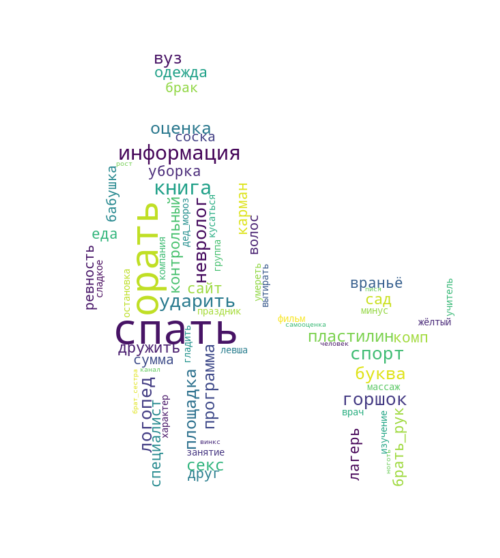

In [35]:
topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name='137_Top2Vec1_Reduced_0')
wordmap_df = topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))
Mask_Image_filename='mom_and_kid.png'
Mask_Image_full_filename=os.path.join(Images, Mask_Image_filename)
wc = topics_size_word_map(wordmap_dict, mask_image_file=Mask_Image_full_filename,  width=1600, height=1000)

In [31]:
#wc.to_file(TopicsSizeWordCloud_full_filename)

In [ ]:
reduced_topics_df=ReducedTopicsData(model,num_topics=num_reduced)

In [ ]:
model_coherence(model, data, reduced=True,num_topics=num_reduced)

0.6192631585043092

In [ ]:
reduced_topics_df

,Id,Size,Words,Scores,Mapping,Name
0,0,1680,"крик,орать,начинать,слушаться,истерика,наказыв...","[0.5063856244087219, 0.493164598941803, 0.4924...","[108, 80, 103, 48, 25, 62, 0]",крик
1,1,1602,"оценка,математика,учиться,двойка,математик,кла...","[0.6292730569839478, 0.6188110709190369, 0.596...","[81, 121, 9, 78, 64, 120, 22, 51, 107, 26, 44, 6]",оценка
2,2,1450,"информация,образование,жизнь,семья,социальный,...","[0.5052692890167236, 0.5030787587165833, 0.502...","[33, 106, 97, 73, 76, 90, 99, 3]",информация
3,3,1432,"спать,засыпать,сон,ночь,просыпаться,спасть,кро...","[0.7493017315864563, 0.7194079756736755, 0.695...","[61, 38, 85, 57, 118, 1]",спать
4,4,1176,"еда,одежда,вещь,грязный,стол,макароны,суп,обув...","[0.5871310830116272, 0.5411669015884399, 0.534...","[136, 56, 96, 88, 18, 54, 15, 12]",еда
5,5,1157,"книга,интересный,пособие,сайт,чтение,читать,эн...","[0.5567421913146973, 0.5246583819389343, 0.520...","[36, 65, 92, 46, 50, 53, 66, 70, 82, 138, 27]",книга
6,6,1078,"буква,слог,логопед,звук,речь,произносить,слово...","[0.6968886852264404, 0.6583657264709473, 0.579...","[72, 14, 98, 124, 8]",буква
7,7,1036,"секс,человек,разговор,отношение,переписка,жизн...","[0.4779638648033142, 0.47169584035873413, 0.45...","[67, 126, 35, 116, 87, 135, 95, 89, 131, 132, 13]",секс
8,8,1022,"ударить,бить,драка,толкать,обижать,драться,сда...","[0.5548204779624939, 0.5315463542938232, 0.521...","[49, 110, 2]",ударить
9,9,991,"жить,приезжать,муж,друг,дача,поехать,ездить,вы...","[0.5315968990325928, 0.5063714981079102, 0.503...","[24, 60, 125, 130, 28, 91, 55, 93, 20]",жить


In [ ]:
SaveToExperimentLog(Experiments_file,'Final',reduced_topics_df)

In [20]:
reduced_topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=tab_adj_data)
reduced_topics_df.head()

,Id,Size,Words,Scores,Mapping,Name,Name_eng,Words_eng
0,0,1680,"крик, орать, начинать, слушаться, истерика, на...","[0.5063856244087219, 0.493164598941803, 0.4924...","[108, 80, 103, 48, 25, 62, 0]","поведение, истерики и капризы","behavior, hysteria, and whimsy","shout, yell, yell, start, obey, hysteria, puni..."
1,1,1602,"оценка, математика, учиться, двойка, математик...","[0.6292730569839478, 0.6188110709190369, 0.596...","[81, 121, 9, 78, 64, 120, 22, 51, 107, 26, 44, 6]","школа, учёба и оценки",School and Assessment,"assessment, mathematics, study, two, mathemati..."
2,2,1450,"информация, образование, жизнь, семья, социаль...","[0.5052692890167236, 0.5030787587165833, 0.502...","[33, 106, 97, 73, 76, 90, 99, 3]",современный мир и социальная жизнь,social life,"information, education, life, family, social, ..."
3,3,1432,"спать, засыпать, сон, ночь, просыпаться, спаст...","[0.7493017315864563, 0.7194079756736755, 0.695...","[61, 38, 85, 57, 118, 1]",сон,sleep,"sleep, sleep, sleep, sleep, night, wake up, sl..."
4,4,1176,"еда, одежда, вещь, грязный, стол, макароны, су...","[0.5871310830116272, 0.5411669015884399, 0.534...","[136, 56, 96, 88, 18, 54, 15, 12]",еда и домашние обязонности,Food and Cleaning,"food, clothing, thing, dirty, table, pasta, so..."


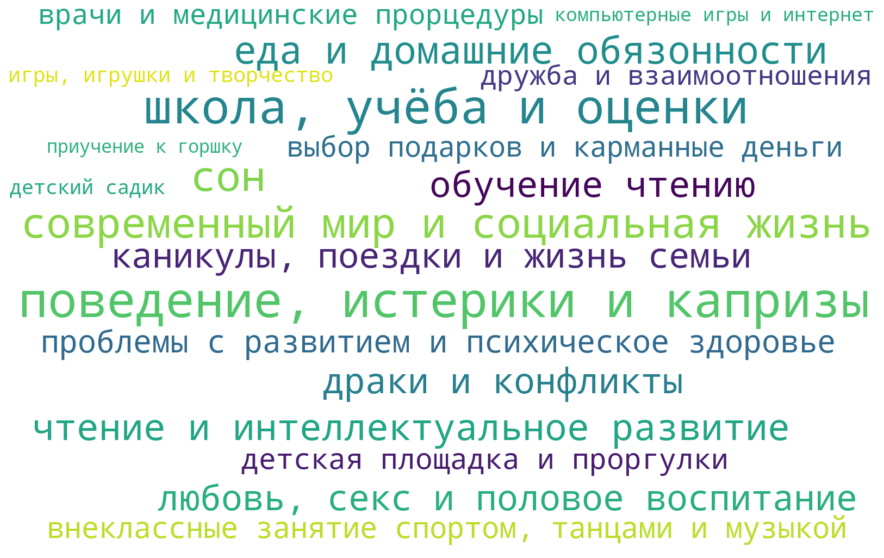

In [21]:
wordmap_df = reduced_topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))

wc = topics_size_word_map(wordmap_dict,   width=1600, height=1000)
#wc.to_file(TopicsSizeWordCloud_full_filename)

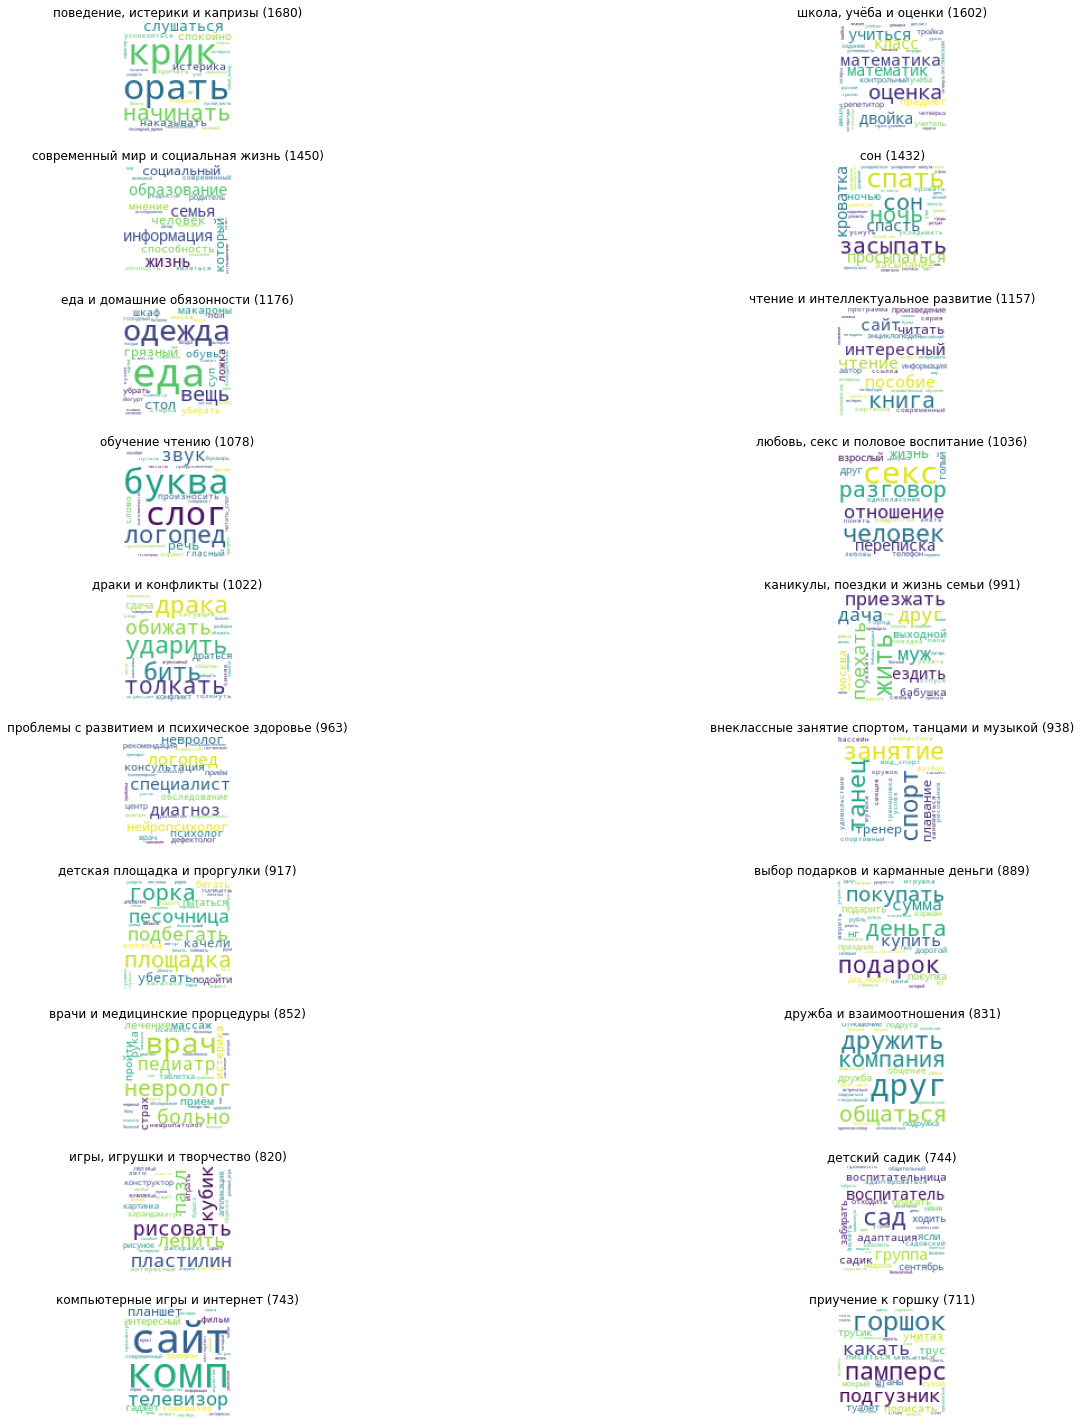

In [33]:
fig = topics_content_word_map(model,reduced=True, nrows=10, ncols=2,  width=100, height=100, width_figsize=20, height_figsize=20, topic_names=reduced_topics_df['Name'].tolist())
#fig.savefig(TopicsContentWordCloud_full_filename)

In [34]:
topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name'].tolist())

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [36]:
fig=topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name'].tolist())
fig.write_html(Distancemap_full_filename)

In [37]:
visualize_heatmap(model,n_clusters=3, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name'].tolist())

In [38]:
fig=visualize_heatmap(model,n_clusters=3, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name'].tolist())
fig.write_html(Heatmap_full_filename)

# Translate to English

In [ ]:
!pip install transformers

In [42]:
from transformers import FSMTForConditionalGeneration, FSMTTokenizer

In [40]:
mname = "facebook/wmt19-ru-en"

In [43]:
tokenizer = FSMTTokenizer.from_pretrained(mname)
translation_model = FSMTForConditionalGeneration.from_pretrained(mname)

Downloading:   0%|          | 0.00/758k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/387k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

In [46]:
def ToEnglish(row,column):
    input = row[column]
    input_ids = tokenizer.encode(input, return_tensors="pt")
    outputs = translation_model.generate(input_ids)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [47]:
reduced_topics_df['Words_eng'] = reduced_topics_df.apply(lambda x: ToEnglish(x, 'Words'), axis=1)

In [48]:
reduced_topics_df['Name_eng'] = reduced_topics_df.apply(lambda x: ToEnglish(x, 'Name'), axis=1)

In [49]:
reduced_topics_df

,Id,Size,Words,Scores,Mapping,Name,Name_eng,Words_eng
0,0,1680,"крик, орать, начинать, слушаться, истерика, на...","[0.5063856244087219, 0.493164598941803, 0.4924...","[108, 80, 103, 48, 25, 62, 0]","поведение, истерики и капризы","behavior, hysteria, and whimsy","shout, shout, start, obey, hysteria, punish, c..."
1,1,1602,"оценка, математика, учиться, двойка, математик...","[0.6292730569839478, 0.6188110709190369, 0.596...","[81, 121, 9, 78, 64, 120, 22, 51, 107, 26, 44, 6]","школа, учёба и оценки","School, Learning and Evaluation","assessment, mathematics, study, two, mathemati..."
2,2,1450,"информация, образование, жизнь, семья, социаль...","[0.5052692890167236, 0.5030787587165833, 0.502...","[33, 106, 97, 73, 76, 90, 99, 3]",современный мир и социальная жизнь,modern world and social life,"information, education, life, family, social, ..."
3,3,1432,"спать, засыпать, сон, ночь, просыпаться, спаст...","[0.7493017315864563, 0.7194079756736755, 0.695...","[61, 38, 85, 57, 118, 1]",сон,sleep,"sleep, sleep, sleep, sleep, night, wake up, sl..."
4,4,1176,"еда, одежда, вещь, грязный, стол, макароны, су...","[0.5871310830116272, 0.5411669015884399, 0.534...","[136, 56, 96, 88, 18, 54, 15, 12]",еда и домашние обязонности,Food and Household Obligations,"food, clothing, thing, dirty, table, pasta, so..."
5,5,1157,"книга, интересный, пособие, сайт, чтение, чита...","[0.5567421913146973, 0.5246583819389343, 0.520...","[36, 65, 92, 46, 50, 53, 66, 70, 82, 138, 27]",чтение и интеллектуальное развитие,Reading and Intellectual Development,"book, interesting, manual, website, reading, r..."
6,6,1078,"буква, слог, логопед, звук, речь, произносить,...","[0.6968886852264404, 0.6583657264709473, 0.579...","[72, 14, 98, 124, 8]",обучение чтению,learning to read,"letter, syllable, speech therapist, sound, spe..."
7,7,1036,"секс, человек, разговор, отношение, переписка,...","[0.4779638648033142, 0.47169584035873413, 0.45...","[67, 126, 35, 116, 87, 135, 95, 89, 131, 132, 13]","любовь, секс и половое воспитание","Love, Sex and Sex Education","sex, man, conversation, attitude, corresponden..."
8,8,1022,"ударить, бить, драка, толкать, обижать, дратьс...","[0.5548204779624939, 0.5315463542938232, 0.521...","[49, 110, 2]",драки и конфликты,Fighting and Conflict,"hit, beat, fight, push, offend, fight, surrend..."
9,9,991,"жить, приезжать, муж, друг, дача, поехать, езд...","[0.5315968990325928, 0.5063714981079102, 0.503...","[24, 60, 125, 130, 28, 91, 55, 93, 20]","каникулы, поездки и жизнь семьи","holidays, trips and family life","live, come, husband, friend, country house, go..."


In [50]:
SaveToExperimentLog(Experiments_file,'Final',reduced_topics_df)

In [51]:
reduced_topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=tab_adj_data)
reduced_topics_df.head()

,Id,Size,Words,Scores,Mapping,Name,Name_eng,Words_eng
0,0,1680,"крик, орать, начинать, слушаться, истерика, на...","[0.5063856244087219, 0.493164598941803, 0.4924...","[108, 80, 103, 48, 25, 62, 0]","поведение, истерики и капризы","Behavior, disobedience and whimsy","shout, shout, start, obey, hysteria, punish, c..."
1,1,1602,"оценка, математика, учиться, двойка, математик...","[0.6292730569839478, 0.6188110709190369, 0.596...","[81, 121, 9, 78, 64, 120, 22, 51, 107, 26, 44, 6]","школа, учёба и оценки","School, Learning and Evaluation","assessment, mathematics, study, F, mathematici..."
2,2,1450,"информация, образование, жизнь, семья, социаль...","[0.5052692890167236, 0.5030787587165833, 0.502...","[33, 106, 97, 73, 76, 90, 99, 3]",современный мир и социальная жизнь,Modern world and social life,"information, education, life, family, social, ..."
3,3,1432,"спать, засыпать, сон, ночь, просыпаться, спаст...","[0.7493017315864563, 0.7194079756736755, 0.695...","[61, 38, 85, 57, 118, 1]",сон,Sleep,"sleep, sleep, sleep, sleep, night, wake up, sl..."
4,4,1176,"еда, одежда, вещь, грязный, стол, макароны, су...","[0.5871310830116272, 0.5411669015884399, 0.534...","[136, 56, 96, 88, 18, 54, 15, 12]",еда и домашние обязонности,Food and Household Chores,"food, clothing, thing, dirty, table, pasta, so..."


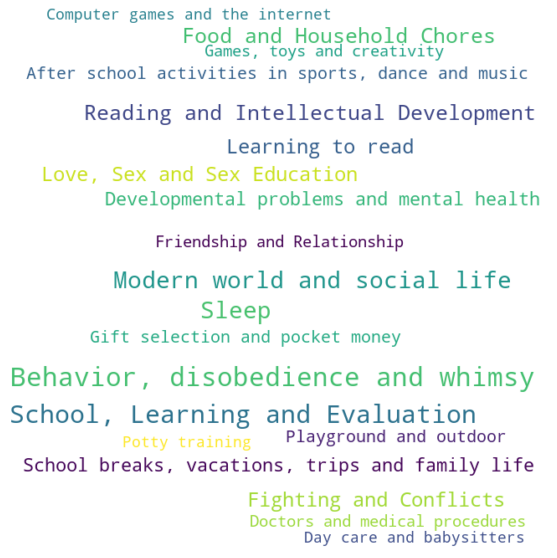

In [52]:
wordmap_df = reduced_topics_df[['Name_eng','Size']].groupby(['Name_eng'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['Name_eng'], wordmap_df['Size']))
wc = topics_size_word_map(wordmap_dict,  width=650, height=650)
#wc.to_file(TopicsSizeWordCloud_full_filename)

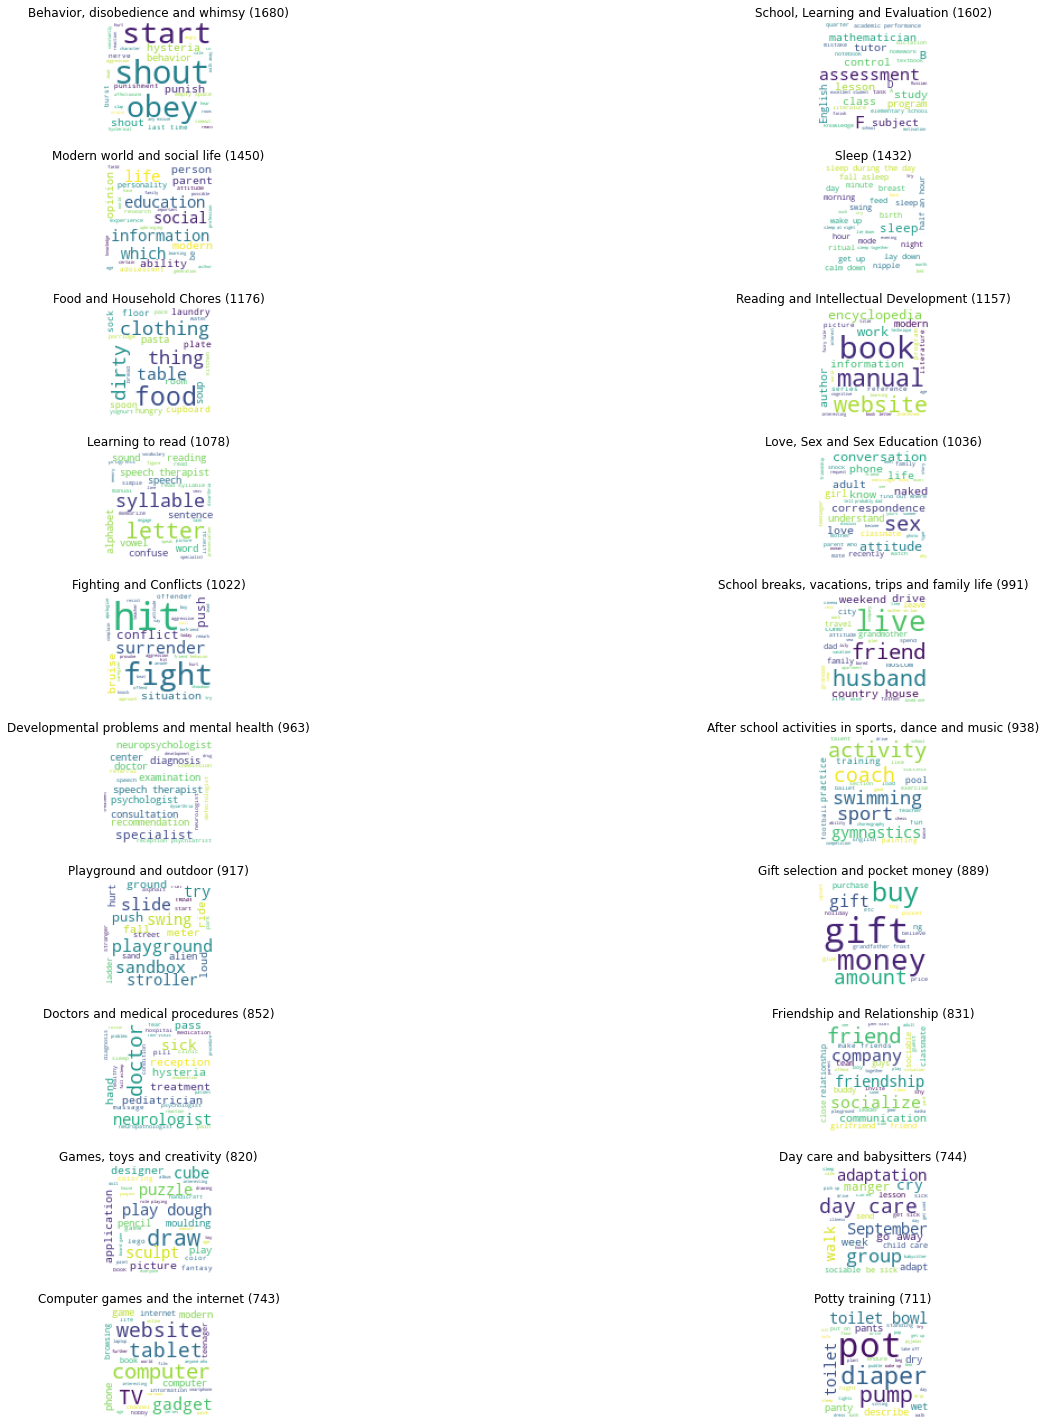

In [56]:
topic_content=reduced_topics_df['Words_eng'].str.split(',').tolist()
fig = topics_content_word_map(model,reduced=True, nrows=10, ncols=2,  width=100, height=100, width_figsize=20, height_figsize=20,topic_content=topic_content, topic_names=reduced_topics_df['Name_eng'].tolist())
fig.savefig(TopicsContentWordCloud_full_filename_eng)

In [57]:
topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name_eng'].tolist())

In [59]:
fig=topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name_eng'].tolist())
fig.write_html(Distancemap_full_filename_eng)

In [61]:
visualize_heatmap(model,n_clusters=3, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name_eng'].tolist())

In [63]:
fig=visualize_heatmap(model,n_clusters=3, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name_eng'].tolist())
fig.write_html(Heatmap_full_filename_eng)

In [76]:
topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name='137_Top2Vec1_Reduced_0')
topics_df.head()

,Id,Size,Words,Scores,Mapping,Name
0,0,918,"орать,крик,истерика,слушаться,начинать,успокои...","[0.5154011845588684, 0.5150542259216309, 0.506...","[62, 0]",орать
1,1,866,"спать,засыпать,сон,ночь,просыпаться,спасть,зас...","[0.7526738047599792, 0.7209509015083313, 0.699...","[118, 1]",спать
2,2,806,"информация,образование,социальный,жизнь,семья,...","[0.5222585201263428, 0.510215699672699, 0.4996...","[106, 97, 73, 76, 90, 99, 3]",информация
3,3,658,"ударить,драка,бить,толкать,драться,конфликт,об...","[0.5435766577720642, 0.5424178242683411, 0.523...","[110, 2]",ударить
4,4,594,"спорт,занятие,танец,тренер,плавание,вид_спорт,...","[0.6229524612426758, 0.6205341815948486, 0.603...","[109, 128, 4]",спорт


In [77]:
topics_df['Name_eng'] = topics_df.apply(lambda x: ToEnglish(x, 'Name'), axis=1)

In [84]:
SaveToExperimentLog(Experiments_file,'137_Top2Vec1_Reduced_0',topics_df)

In [85]:
topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name='137_Top2Vec1_Reduced_0')
topics_df.head()

,Id,Size,Words,Scores,Mapping,Name,Name_eng
0,0,918,"орать,крик,истерика,слушаться,начинать,успокои...","[0.5154011845588684, 0.5150542259216309, 0.506...","[62, 0]",орать,Shout
1,1,866,"спать,засыпать,сон,ночь,просыпаться,спасть,зас...","[0.7526738047599792, 0.7209509015083313, 0.699...","[118, 1]",спать,Sleeping
2,2,806,"информация,образование,социальный,жизнь,семья,...","[0.5222585201263428, 0.510215699672699, 0.4996...","[106, 97, 73, 76, 90, 99, 3]",информация,information
3,3,658,"ударить,драка,бить,толкать,драться,конфликт,об...","[0.5435766577720642, 0.5424178242683411, 0.523...","[110, 2]",ударить,strike
4,4,594,"спорт,занятие,танец,тренер,плавание,вид_спорт,...","[0.6229524612426758, 0.6205341815948486, 0.603...","[109, 128, 4]",спорт,sports


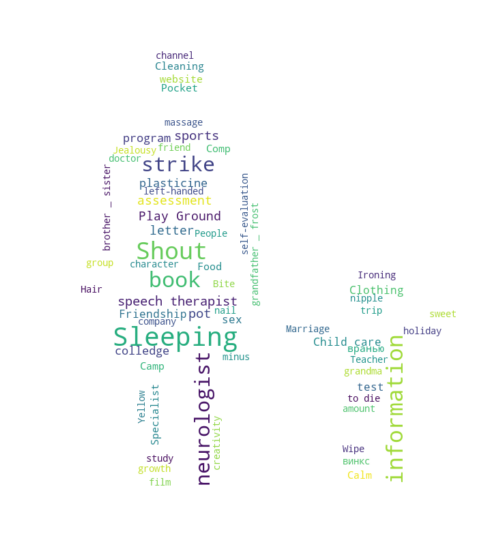

In [90]:
wordmap_df = topics_df[['Name_eng','Size']].groupby(['Name_eng'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['Name_eng'], wordmap_df['Size']))
Mask_Image_filename='mom_and_kid.png'
Mask_Image_full_filename=os.path.join(Images, Mask_Image_filename)
wc = topics_size_word_map(wordmap_dict, mask_image_file=Mask_Image_full_filename,  width=1600, height=1000)

In [91]:
wc.to_file(TopicsSizeWordCloud_full_filename_eng)